C:\Users\Arush\AppData\Local\Temp\ipykernel_9012\1110288434.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()
C:\Users\Arush\AppData\Local\Temp\ipykernel_9012\1110288434.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax23.set_xticklabels([d.strftime("%m-%d") for d in w15.index], rotation=45, ha='right')
C:\Users\Arush\AppData\Local\Temp\ipykernel_9012\1110288434.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()
C:\Users\Arush\AppData\Local\Temp\ipykernel_9012\1110288434.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig3.tight_layout()


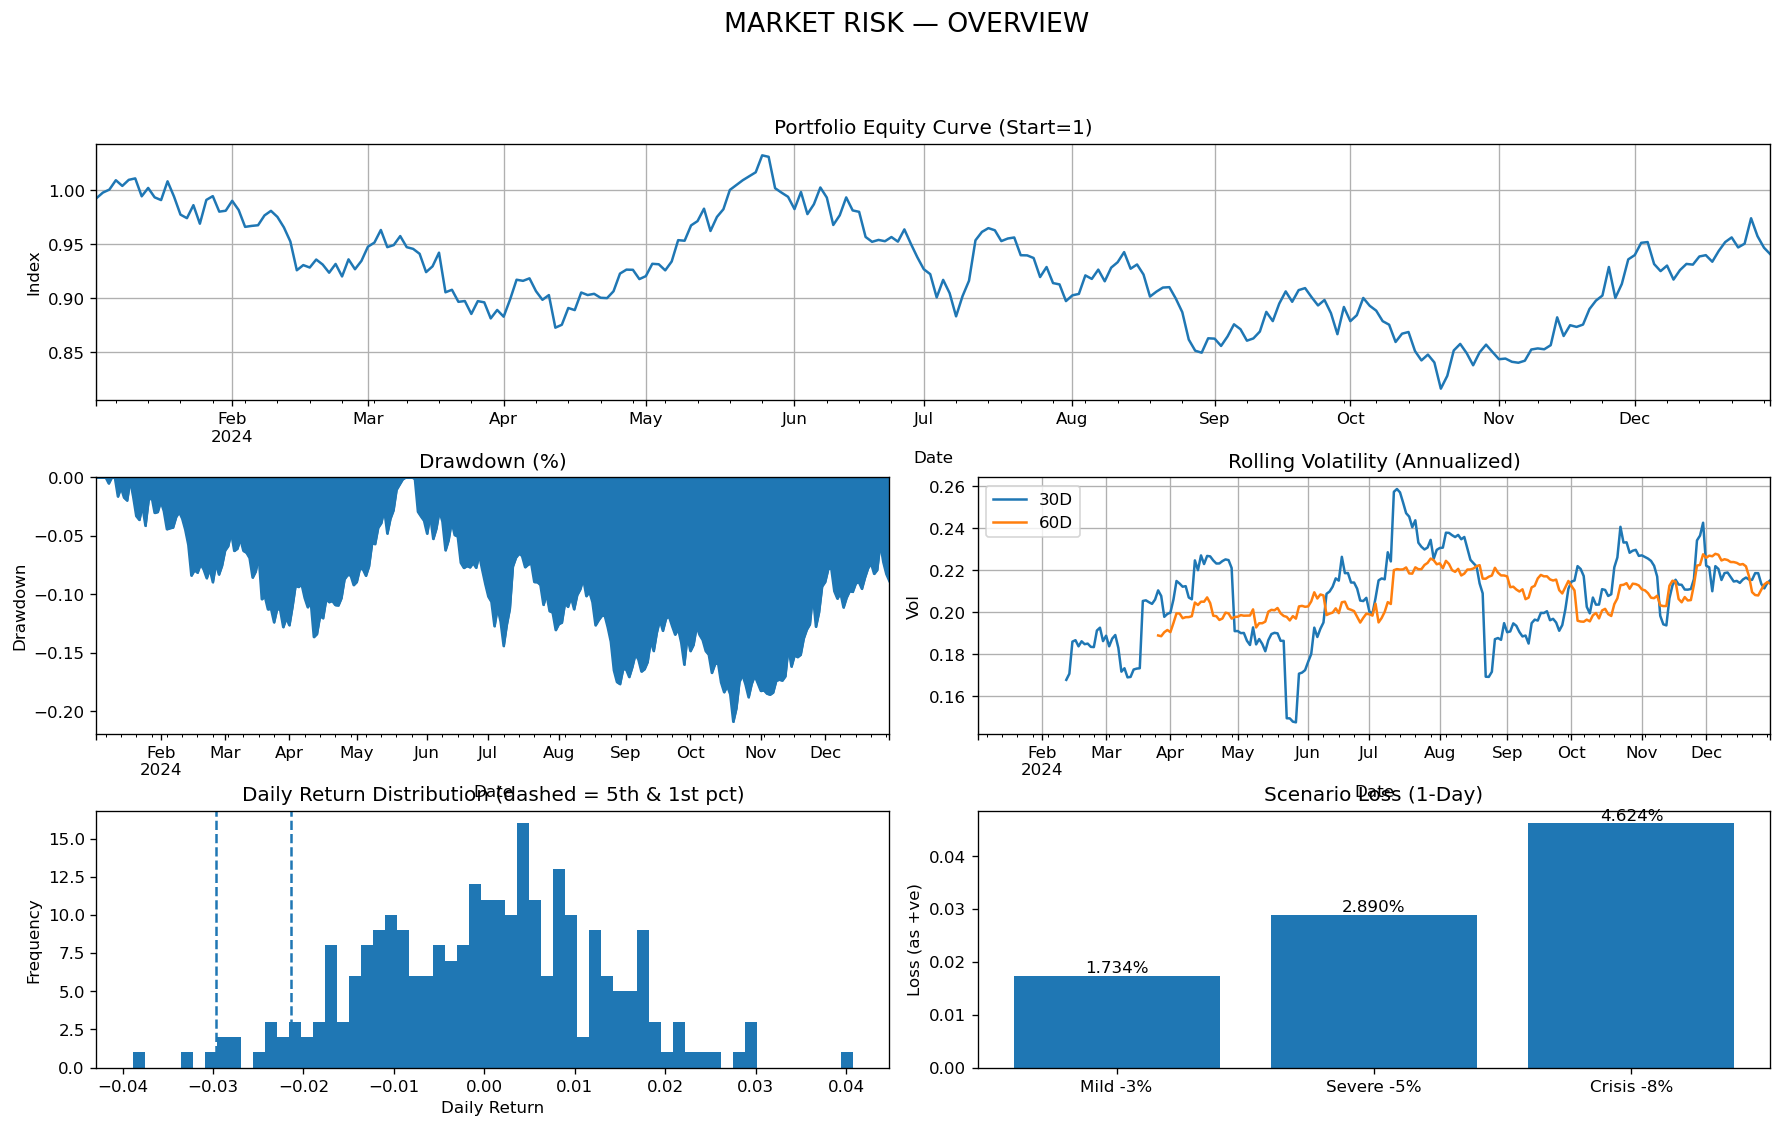

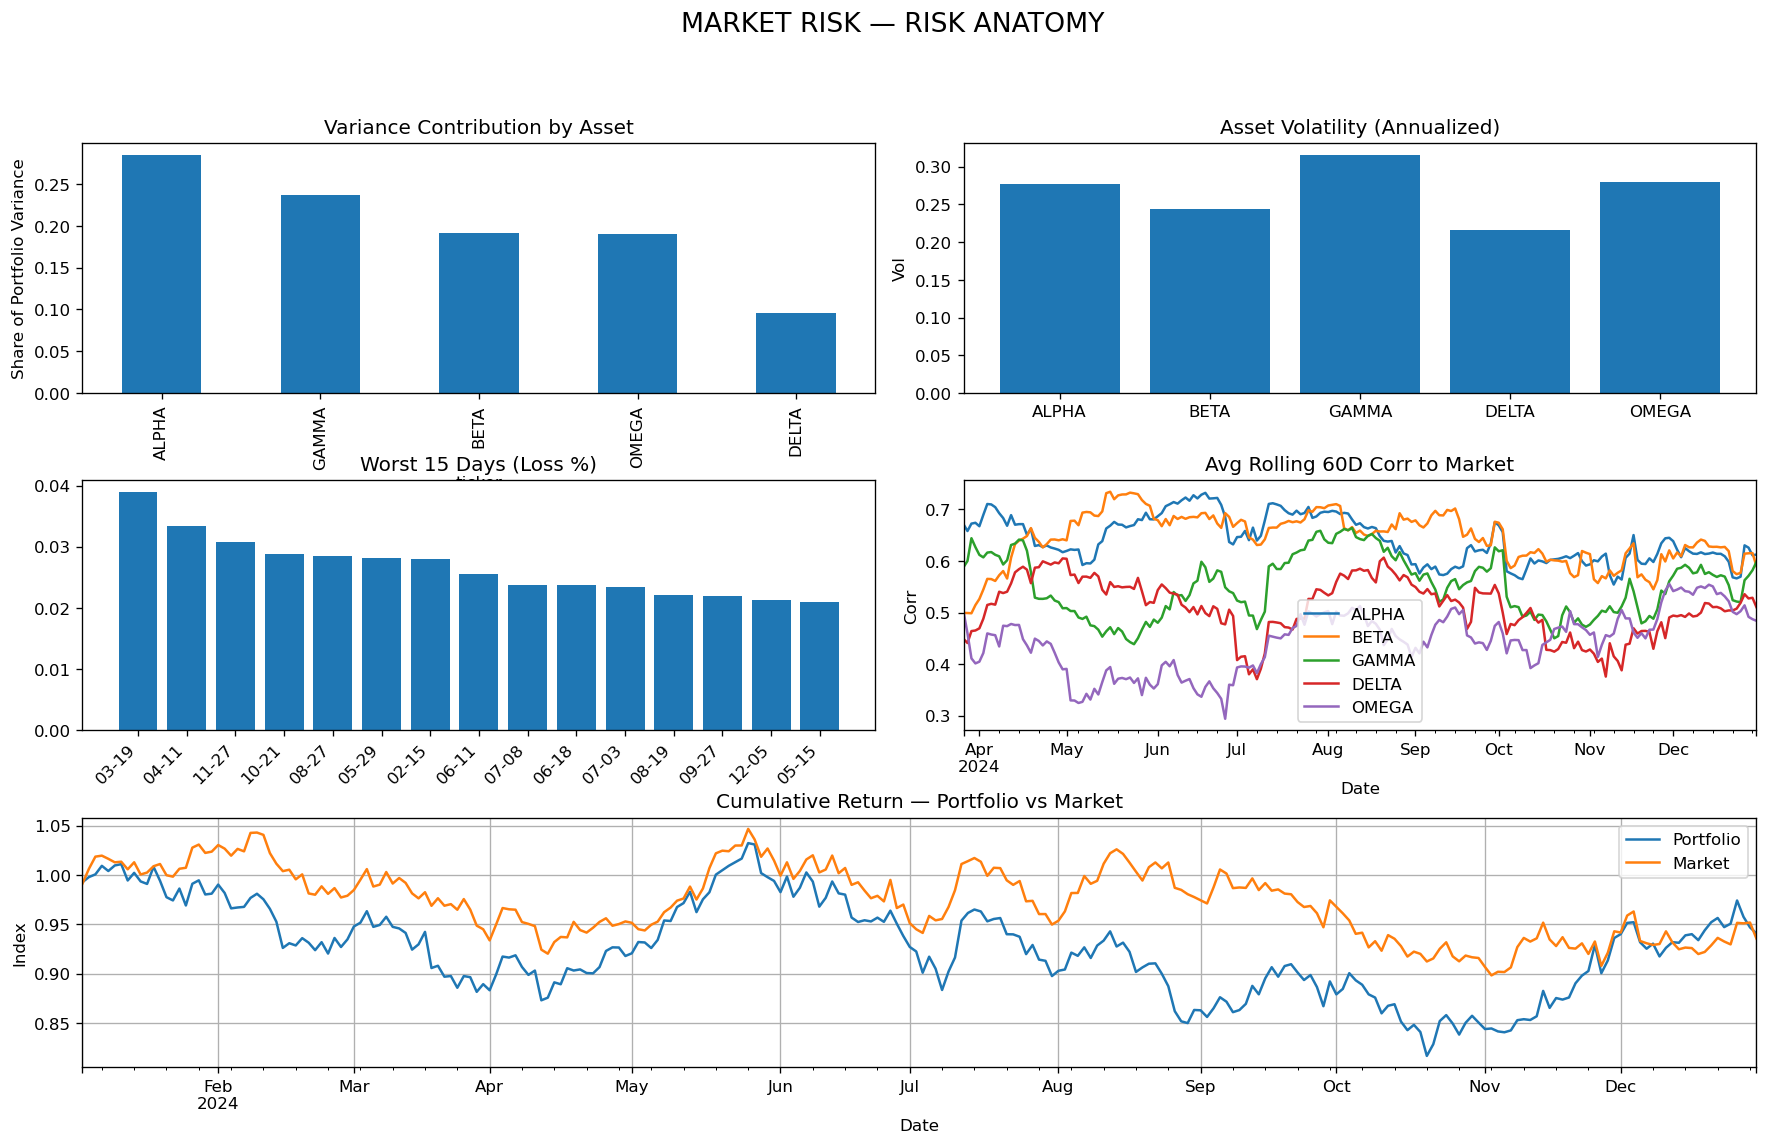

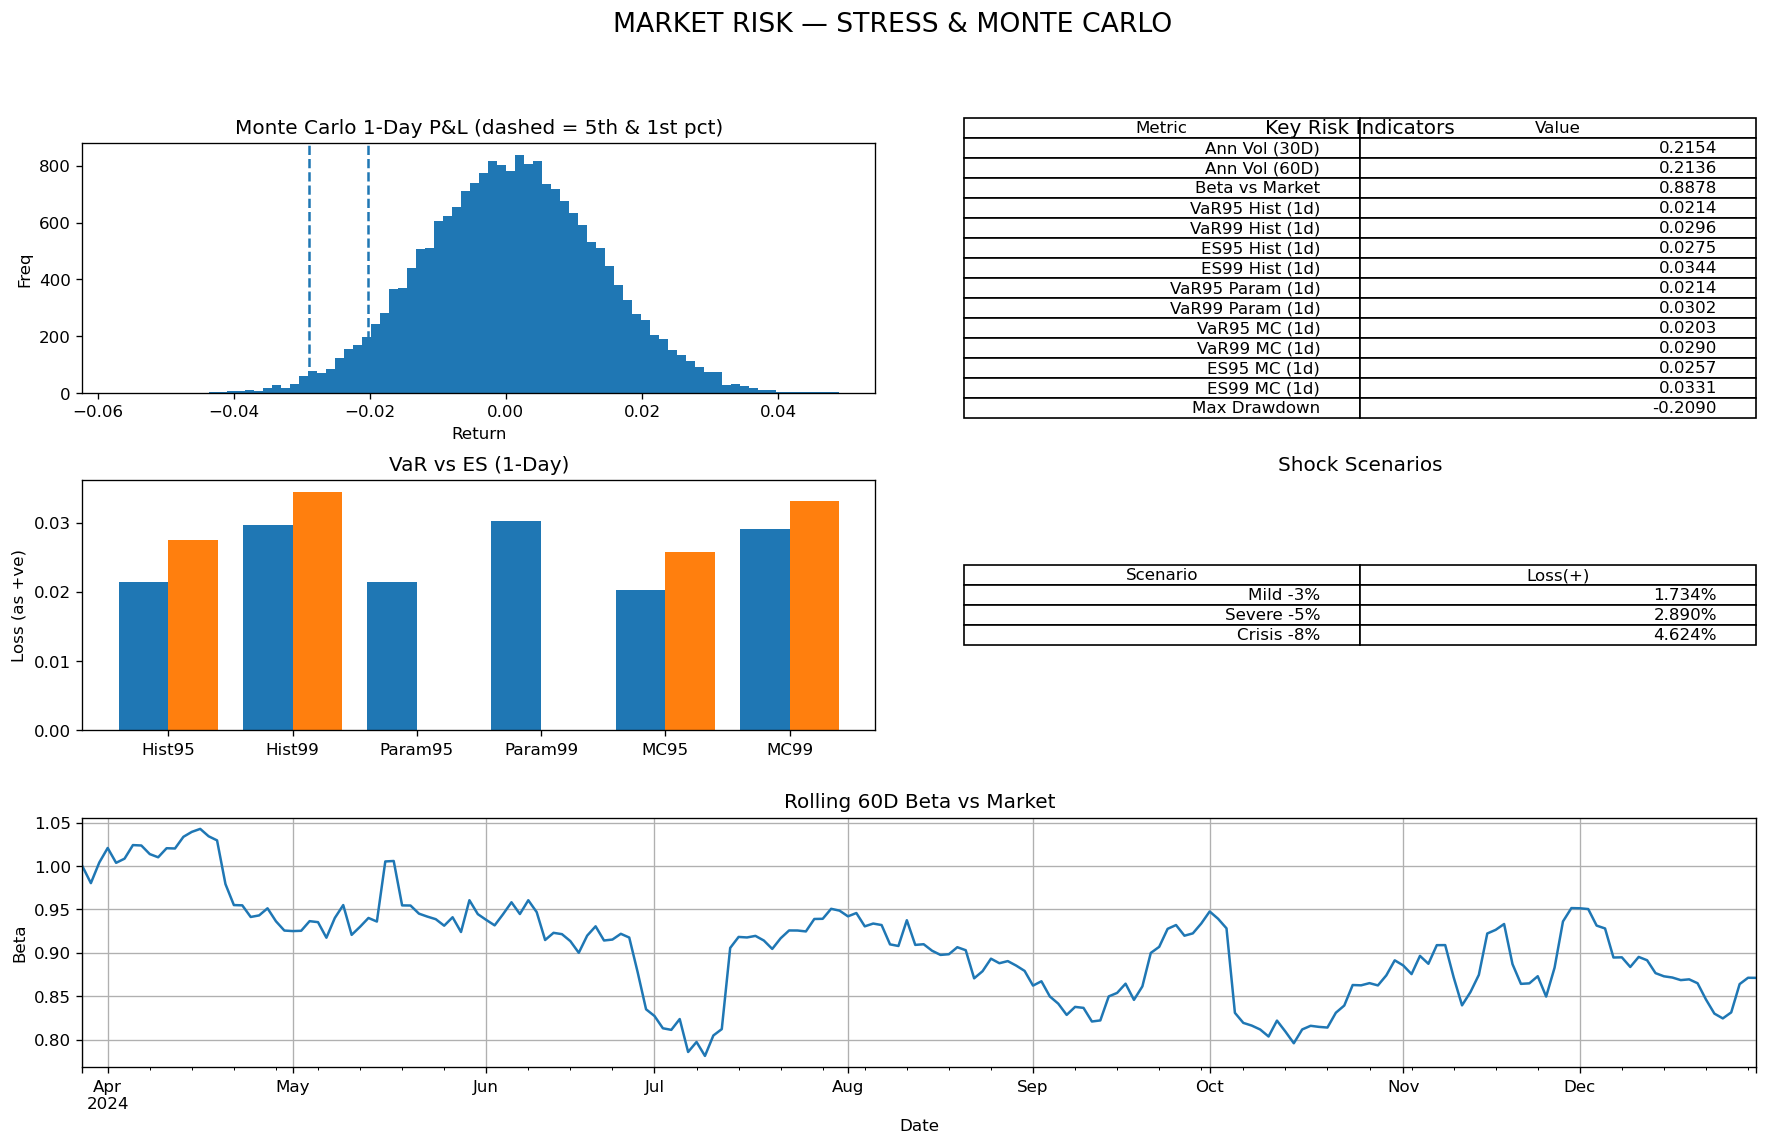


=== KEY RISK INDICATORS ===


,Metric,Value
0,Ann Vol (30D),0.215355
1,Ann Vol (60D),0.213554
2,Beta vs Market,0.887767
3,VaR95 Hist (1d),0.021381
4,VaR99 Hist (1d),0.029643
5,ES95 Hist (1d),0.027454
6,ES99 Hist (1d),0.034367
7,VaR95 Param (1d),0.021384
8,VaR99 Param (1d),0.030180
9,VaR95 MC (1d),0.020260



=== VARIANCE CONTRIBUTION ===


,ticker,variance_contrib,marginal_var
0,ALPHA,0.284698,0.014699
1,GAMMA,0.237103,0.015302
2,BETA,0.191541,0.012362
3,OMEGA,0.190732,0.012310
4,DELTA,0.095926,0.008255



=== SCENARIOS (Loss shown as +) ===


,scenario,Loss(+)
0,Mild -3%,1.734%
1,Severe -5%,2.890%
2,Crisis -8%,4.624%


In [2]:
# ==========================================
# MARKET RISK — BIG DASHBOARDS (PURE JUPYTER)
# Pages: 1) Overview  2) Risk Anatomy  3) Stress & Monte Carlo
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) CONFIG ----------
np.random.seed(11)

tickers = ["ALPHA","BETA","GAMMA","DELTA","OMEGA","NIFTY50"]   # last is market index (not held)
weights = pd.Series({"ALPHA":0.25,"BETA":0.20,"GAMMA":0.20,"DELTA":0.15,"OMEGA":0.20})
assert abs(weights.sum()-1)<1e-8, "Weights must sum to 1"

start_prices = {"ALPHA":120,"BETA":80,"GAMMA":60,"DELTA":150,"OMEGA":95,"NIFTY50":22000}
dates = pd.bdate_range("2024-01-02","2024-12-31")

mu_a  = np.array([0.12,0.10,0.14,0.08,0.11,0.09])  # annual drift
sig_a = np.array([0.28,0.24,0.32,0.22,0.27,0.18])  # annual vol

corr = np.array([
    [1.00,0.62,0.55,0.45,0.50,0.66],
    [0.62,1.00,0.50,0.40,0.46,0.61],
    [0.55,0.50,1.00,0.35,0.40,0.56],
    [0.45,0.40,0.35,1.00,0.32,0.50],
    [0.50,0.46,0.40,0.32,1.00,0.52],
    [0.66,0.61,0.56,0.50,0.52,1.00]
])

# ---------- 1) SYNTHETIC PRICES (Correlated GBM) ----------
N = len(dates); D = len(tickers); tdays = 252
mu_d  = mu_a/tdays
sig_d = sig_a/np.sqrt(tdays)

L = np.linalg.cholesky(corr)
Z = np.random.randn(N, D) @ L.T
drift = (mu_d - 0.5*sig_d**2)
log_ret = drift + Z * sig_d
ret = np.exp(log_ret) - 1

prices = []
for j,t in enumerate(tickers):
    s = np.empty(N); s[0] = start_prices[t]
    for i in range(1,N):
        s[i] = s[i-1]*(1+ret[i,j])
    prices.append(s)

px = pd.DataFrame(np.column_stack(prices), index=dates, columns=tickers)
rets = px.pct_change().dropna()

# ---------- 2) PORTFOLIO & CORE SERIES ----------
port_ret = (rets[weights.index] * weights).sum(axis=1).rename("port_ret")
equity = (1+port_ret).cumprod()
peak = equity.cummax()
drawdown = equity/peak - 1.0

roll30 = port_ret.rolling(30).std()*np.sqrt(252)
roll60 = port_ret.rolling(60).std()*np.sqrt(252)

# Beta vs market
if "NIFTY50" in rets.columns:
    aligned = pd.concat([port_ret, rets["NIFTY50"]], axis=1).dropna()
    beta = aligned.cov().iloc[0,1] / aligned["NIFTY50"].var()
else:
    beta = np.nan

# ---------- 3) RISK METRICS (Hist + Parametric) ----------
r = port_ret.dropna().values
def hist_var(series, alpha=0.95):
    q = np.percentile(series, (1-alpha)*100)
    return -q
def hist_es(series, alpha=0.95):
    q = np.percentile(series, (1-alpha)*100)
    tail = series[series<=q]
    return -(tail.mean() if len(tail) else np.nan)

VaR95_hist, VaR99_hist = hist_var(r,.95), hist_var(r,.99)
ES95_hist, ES99_hist   = hist_es(r,.95),  hist_es(r,.99)

mu = port_ret.mean(); sigma = port_ret.std()
from scipy.stats import norm
VaR95_para = -(mu + sigma*norm.ppf(0.05))
VaR99_para = -(mu + sigma*norm.ppf(0.01))

# ---------- 4) RISK CONTRIBUTIONS ----------
cov_mat = rets[weights.index].cov()
w = weights.values
port_var = float(w @ cov_mat.values @ w)
marginal_var = (cov_mat.values @ w) / np.sqrt(port_var) if port_var>0 else np.zeros_like(w)
var_contrib = (w * (cov_mat.values @ w)) / port_var if port_var>0 else np.zeros_like(w)
risk_contrib = (pd.DataFrame({
    "ticker": weights.index,
    "variance_contrib": var_contrib,
    "marginal_var": marginal_var
}).sort_values("variance_contrib", ascending=False))

# Worst 15 days for the big board
worst15 = port_ret.sort_values().head(15).to_frame()
worst15["loss_%"] = -worst15["port_ret"]

# ---------- 5) SCENARIOS & MONTE CARLO ----------
# Simple shock scenarios on the last price vector: -3%, -5%, -8% market day with correlation spread
shock_map = {"Mild -3%":-0.03, "Severe -5%":-0.05, "Crisis -8%":-0.08}
# tie asset shocks to market via correlation row with NIFTY50
idx = tickers.index("NIFTY50")
corr_to_mkt = corr[:len(weights), idx]  # portfolio assets vs market
scen = []
for name, shock in shock_map.items():
    # scale each asset shock by correlation intensity
    asset_shocks = shock * corr_to_mkt
    scen_pnl = np.dot(asset_shocks, w)  # one-day portfolio P&L approx
    scen.append((name, scen_pnl))
scenarios = pd.DataFrame(scen, columns=["scenario","port_ret"])

# Monte Carlo one-day
sim_n = 20000
L_port = np.linalg.cholesky(corr[:len(weights),:len(weights)])
Z_mc = np.random.randn(sim_n, len(weights)) @ L_port.T
one_day = mu_d[:len(weights)] + Z_mc * sig_d[:len(weights)]
one_day_simple = np.exp(one_day) - 1
port_sim = one_day_simple @ w
VaR95_mc = -np.percentile(port_sim,5)
VaR99_mc = -np.percentile(port_sim,1)
ES95_mc  = -port_sim[port_sim<=np.percentile(port_sim,5)].mean()
ES99_mc  = -port_sim[port_sim<=np.percentile(port_sim,1)].mean()

# ---------- 6) KPI TABLE ----------
kpi = pd.DataFrame({
    "Metric":[
        "Ann Vol (30D)","Ann Vol (60D)","Beta vs Market",
        "VaR95 Hist (1d)","VaR99 Hist (1d)","ES95 Hist (1d)","ES99 Hist (1d)",
        "VaR95 Param (1d)","VaR99 Param (1d)",
        "VaR95 MC (1d)","VaR99 MC (1d)","ES95 MC (1d)","ES99 MC (1d)",
        "Max Drawdown"
    ],
    "Value":[
        roll30.dropna().iloc[-1] if roll30.notna().any() else np.nan,
        roll60.dropna().iloc[-1] if roll60.notna().any() else np.nan,
        beta,
        VaR95_hist, VaR99_hist, ES95_hist, ES99_hist,
        VaR95_para, VaR99_para,
        VaR95_mc, VaR99_mc, ES95_mc, ES99_mc,
        drawdown.min()
    ]
})

# ---------- 7) BIG DASHBOARD PAGES ----------
plt.rcParams["figure.dpi"] = 120

# PAGE 1 — OVERVIEW
fig1 = plt.figure(figsize=(18,10))
gs = fig1.add_gridspec(3, 4, hspace=0.3, wspace=0.25)

# 1A Equity (full width top)
ax1 = fig1.add_subplot(gs[0, :])
equity.plot(ax=ax1)
ax1.set_title("Portfolio Equity Curve (Start=1)")
ax1.set_xlabel("Date"); ax1.set_ylabel("Index")
ax1.grid(True)

# 1B Drawdown
ax2 = fig1.add_subplot(gs[1, :2])
drawdown.plot(kind="area", ax=ax2)
ax2.set_title("Drawdown (%)"); ax2.set_xlabel("Date"); ax2.set_ylabel("Drawdown")
ax2.axhline(0, linewidth=1)

# 1C Rolling Vol
ax3 = fig1.add_subplot(gs[1, 2:])
roll30.plot(ax=ax3, label="30D"); roll60.plot(ax=ax3, label="60D")
ax3.set_title("Rolling Volatility (Annualized)"); ax3.set_xlabel("Date"); ax3.set_ylabel("Vol")
ax3.legend(); ax3.grid(True)

# 1D Return histogram + VaR markers
ax4 = fig1.add_subplot(gs[2, :2])
ax4.hist(port_ret.dropna(), bins=60)
ax4.axvline(np.percentile(r,5), linestyle='--')
ax4.axvline(np.percentile(r,1), linestyle='--')
ax4.set_title("Daily Return Distribution (dashed = 5th & 1st pct)")
ax4.set_xlabel("Daily Return"); ax4.set_ylabel("Frequency")

# 1E Scenario bars
ax5 = fig1.add_subplot(gs[2, 2:])
ax5.bar(scenarios["scenario"], -scenarios["port_ret"])
ax5.set_title("Scenario Loss (1-Day)")
ax5.set_ylabel("Loss (as +ve)"); ax5.set_xlabel("")
for i,v in enumerate(-scenarios["port_ret"]):
    ax5.text(i, v, f"{v:.3%}", ha='center', va='bottom', rotation=0)

fig1.suptitle("MARKET RISK — OVERVIEW", y=0.99, fontsize=16)
fig1.tight_layout()
# fig1.savefig("dashboard_overview.png", dpi=180)

# PAGE 2 — RISK ANATOMY
fig2 = plt.figure(figsize=(18,10))
gs2 = fig2.add_gridspec(3, 4, hspace=0.35, wspace=0.25)

# 2A Variance Contribution (wide)
ax21 = fig2.add_subplot(gs2[0, :2])
risk_contrib.set_index("ticker")["variance_contrib"].plot(kind="bar", ax=ax21)
ax21.set_title("Variance Contribution by Asset")
ax21.set_ylabel("Share of Portfolio Variance")

# 2B Asset Volatilities
ax22 = fig2.add_subplot(gs2[0, 2:])
asset_vol = rets[weights.index].std()*np.sqrt(252)
ax22.bar(asset_vol.index, asset_vol.values)
ax22.set_title("Asset Volatility (Annualized)")
ax22.set_ylabel("Vol")

# 2C Worst 15 days (bar)
ax23 = fig2.add_subplot(gs2[1, :2])
w15 = worst15.sort_values("port_ret")
ax23.bar([d.strftime("%Y-%m-%d") for d in w15.index], -w15["port_ret"].values)
ax23.set_title("Worst 15 Days (Loss %)")
ax23.set_xticklabels([d.strftime("%m-%d") for d in w15.index], rotation=45, ha='right')

# 2D Rolling Correlation to Market (avg of assets)
ax24 = fig2.add_subplot(gs2[1, 2:])
if "NIFTY50" in rets.columns:
    rc_series = rets[weights.index].rolling(60).corr(rets["NIFTY50"]).dropna()
    avg_corr = rc_series.groupby(level=0).mean()
    avg_corr.plot(ax=ax24)
    ax24.set_title("Avg Rolling 60D Corr to Market")
    ax24.set_xlabel("Date"); ax24.set_ylabel("Corr")

# 2E Cumulative Returns: Portfolio vs Market
ax25 = fig2.add_subplot(gs2[2, :])
cum_port = (1+port_ret).cumprod()
if "NIFTY50" in rets.columns:
    cum_mkt = (1+rets["NIFTY50"]).cumprod()
    pd.concat([cum_port.rename("Portfolio"), cum_mkt.rename("Market")], axis=1).plot(ax=ax25)
else:
    cum_port.rename("Portfolio").plot(ax=ax25)
ax25.set_title("Cumulative Return — Portfolio vs Market")
ax25.set_xlabel("Date"); ax25.set_ylabel("Index")
ax25.grid(True)

fig2.suptitle("MARKET RISK — RISK ANATOMY", y=0.99, fontsize=16)
fig2.tight_layout()
# fig2.savefig("dashboard_risk_anatomy.png", dpi=180)

# PAGE 3 — STRESS & MONTE CARLO
fig3 = plt.figure(figsize=(18,10))
gs3 = fig3.add_gridspec(3, 4, hspace=0.35, wspace=0.25)

# 3A Monte Carlo distribution
ax31 = fig3.add_subplot(gs3[0, :2])
ax31.hist(port_sim, bins=80)
ax31.axvline(np.percentile(port_sim,5), linestyle='--')
ax31.axvline(np.percentile(port_sim,1), linestyle='--')
ax31.set_title("Monte Carlo 1-Day P&L (dashed = 5th & 1st pct)")
ax31.set_xlabel("Return"); ax31.set_ylabel("Freq")

# 3B KPI table (render as text)
ax32 = fig3.add_subplot(gs3[0, 2:])
ax32.axis('off')
tbl = kpi.copy(); tbl["Value"] = tbl["Value"].map(lambda x: f"{x:.4f}" if pd.notnull(x) else "")
ax32.table(cellText=tbl.values, colLabels=tbl.columns, loc='center')
ax32.set_title("Key Risk Indicators")

# 3C ES vs VaR (all methods)
ax33 = fig3.add_subplot(gs3[1, :2])
labels = ["Hist95","Hist99","Param95","Param99","MC95","MC99"]
var_vals = [VaR95_hist,VaR99_hist,VaR95_para,VaR99_para,VaR95_mc,VaR99_mc]
es_vals  = [ES95_hist,ES99_hist,np.nan,np.nan,ES95_mc,ES99_mc]
x = np.arange(len(labels))
ax33.bar(x-0.2, var_vals, width=0.4)
ax33.bar(x+0.2, [v if v==v else 0 for v in es_vals], width=0.4)  # simple NaN-safe
ax33.set_xticks(x); ax33.set_xticklabels(labels)
ax33.set_title("VaR vs ES (1-Day)")
ax33.set_ylabel("Loss (as +ve)")

# 3D Scenario table (text)
ax34 = fig3.add_subplot(gs3[1, 2:])
ax34.axis('off')
sc = scenarios.copy(); sc["Loss(+)"] = (-sc["port_ret"]).map(lambda x: f"{x:.3%}")
ax34.table(cellText=sc[["scenario","Loss(+)"]].values, colLabels=["Scenario","Loss(+)"], loc='center')
ax34.set_title("Shock Scenarios")

# 3E Rolling Beta (optional mini plot)
ax35 = fig3.add_subplot(gs3[2, :])
if "NIFTY50" in rets.columns:
    # rolling beta via covariance ratio in a 60D window
    rb = pd.Series(index=rets.index, dtype=float)
    win = 60
    for i in range(win, len(aligned)):
        window = aligned.iloc[i-win:i]
        b = window.cov().iloc[0,1] / window["NIFTY50"].var()
        rb.iloc[i] = b
    rb.dropna().plot(ax=ax35)
    ax35.set_title("Rolling 60D Beta vs Market")
    ax35.set_xlabel("Date"); ax35.set_ylabel("Beta")
    ax35.grid(True)

fig3.suptitle("MARKET RISK — STRESS & MONTE CARLO", y=0.99, fontsize=16)
fig3.tight_layout()
# fig3.savefig("dashboard_stress_mc.png", dpi=180)

plt.show()

# ---------- 8) NICE TABLE PRINTS ----------
pd.options.display.float_format = "{:.6f}".format
print("\n=== KEY RISK INDICATORS ===")
display(kpi)
print("\n=== VARIANCE CONTRIBUTION ===")
display(risk_contrib.reset_index(drop=True))
print("\n=== SCENARIOS (Loss shown as +) ===")
display(sc[["scenario","Loss(+)"]])